In [3]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
from scipy.linalg import svd

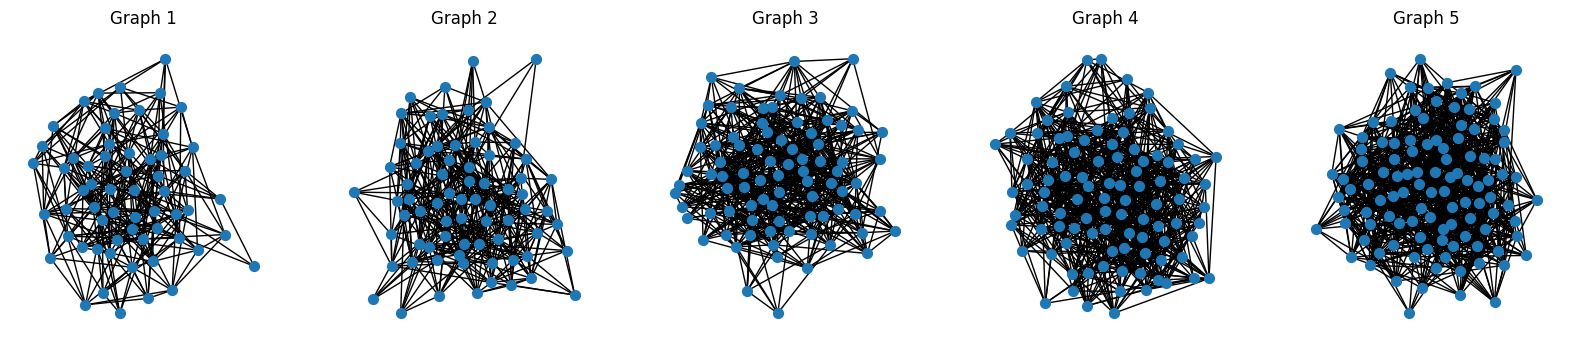

In [16]:
def generate_3clust_sequence(cluster_sizes, pc=0.3, pg=0.1, reverse_after=None):
    """
    Generates a sequence of synthetic graphs based on the description in the paper.

    Args:
        cluster_sizes (list of int): List of sizes of clusters at each step.
        pc (float): Probability of edges within the same cluster.
        pg (float): Probability of edges between different clusters.
        reverse_after (int, optional): Step at which to reverse the sequence.

    Returns:
        list of networkx.Graph: Sequence of generated graphs.
    """
    graphs = []
    num_steps = len(cluster_sizes)
    
    for step, size in enumerate(cluster_sizes):
        cluster_sizes_step = [size] * 3  # Three clusters of equal size
        num_vertices = sum(cluster_sizes_step)
        
        # Create adjacency matrix
        adjacency_matrix = np.zeros((num_vertices, num_vertices))
        
        start = 0
        for cluster_idx, cluster_size in enumerate(cluster_sizes_step):
            # Within-cluster edges
            end = start + cluster_size
            cluster_indices = range(start, end)
            for i in cluster_indices:
                for j in cluster_indices:
                    if i < j and np.random.rand() < pc:
                        adjacency_matrix[i, j] = adjacency_matrix[j, i] = 1
            
            start = end
        
        # Between-cluster edges
        for i in range(num_vertices):
            for j in range(num_vertices):
                if adjacency_matrix[i, j] == 0 and i < j:
                    cluster_i = sum(i >= np.cumsum(cluster_sizes_step))
                    cluster_j = sum(j >= np.cumsum(cluster_sizes_step))
                    if cluster_i != cluster_j and np.random.rand() < pg:
                        adjacency_matrix[i, j] = adjacency_matrix[j, i] = 1
        
        # Convert adjacency matrix to a graph
        graph = nx.from_numpy_array(adjacency_matrix)
        graphs.append(graph)
    
    # Add reversed sequence after a certain step
    if reverse_after is not None and reverse_after < num_steps:
        reverse_graphs = graphs[reverse_after - 1::-1]
        graphs.extend(reverse_graphs)
    
    return graphs

# Define cluster sizes
cluster_sizes = [20 + 4 * i for i in range(11)]  # Sizes from 20 to 60 with step 4
reverse_after = 10

# Generate graphs
graphs = generate_3clust_sequence(cluster_sizes, pc=0.3, pg=0.1, reverse_after=reverse_after)

# Visualize some of the graphs
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    nx.draw(graphs[i], ax=ax, with_labels=False, node_size=50)
    ax.set_title(f"Graph {i + 1}")
plt.show()


In [26]:
import numpy as np
import networkx as nx
from scipy.linalg import svd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def compute_laplacian(graph):
    # Adjacency matrix and degree matrix
    A = nx.adjacency_matrix(graph).toarray()
    D = np.diag(np.sum(A, axis=1))
    
    # Normalized Laplacian: L = D^(-1/2) * (D - A) * D^(-1/2)
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    L = D_inv_sqrt @ (D - A) @ D_inv_sqrt
    return L

def eigenapprox(C, U, k):
    # U = y1y2T + y2y1T
    # Want to find Q such that Ck + U = Q∆QT

    # define U as Y1Y2^T + Y2Y1^T
    Y1, Y2 = np.split(U, 2, axis=1)
    U = Y1 @ Y2.T + Y2 @ Y1.T
    
    # deflate Y1 into the orthogonal space of Qk
    Qk = C[:, :k]
    Y1_deflated = (np.eye(Y1.shape[0]) - Qk @ Qk.T) @ Y1
    
    # xompute the SVD of Y1 after deflation and store the left singular vectors as P1
    _, _, P1 = svd(Y1_deflated, full_matrices=False)
    P1 = P1.T
    
    # deflate Y2 into the orthogonal space of both Qk and P1
    Y2_deflated = (np.eye(Y2.shape[0]) - Qk @ Qk.T - P1 @ P1.T) @ Y2
    _, _, P2 = svd(Y2_deflated, full_matrices=False)
    P2 = P2.T
    
    # define the matrix Q as [Qk, P1, P2]
    Q = np.hstack((Qk, P1, P2))
    
    # compute ∆ from the formula Ck + U = Q∆Q^T
    Delta = Q.T @ (C + U) @ Q
    
    # compute the rank-k eigendecomposition of Delta
    eigenvalues, eigenvectors = np.linalg.eig(Delta)
    idx = eigenvalues.argsort()[::-1]
    Hk = eigenvectors[:, idx[:k]]
    pik = np.diag(eigenvalues[idx[:k]])
    
    # compute the final approximation
    Q_Hk = Q @ Hk
    return Q_Hk, pik
def extend_eigenvectors_for_new_nodes(eigenvectors, new_size):
    current_size = eigenvectors.shape[0]
    
    # If the new size is larger, extend the eigenvectors matrix
    if new_size > current_size:
        extended_eigenvectors = np.zeros((new_size, eigenvectors.shape[1]))
        extended_eigenvectors[:current_size, :] = eigenvectors
        return extended_eigenvectors
    return eigenvectors

def iasc_with_eigenapprox(graphs, num_clusters=3, max_iter=10, k=3):
    # Initialize variables
    eigenvectors_all = None
    eigenvalues_all = None
    
    # Process each graph in the sequence
    for graph_idx, graph in enumerate(graphs):
        print(f"Processing graph {graph_idx + 1}...")
        
        # Compute the Laplacian matrix for the current graph
        C = compute_laplacian(graph)
        print("C", C.shape)
        
        # If it's the first graph, initialize eigenvectors and eigenvalues
        if graph_idx == 0:
            eigenvectors_all, eigenvalues_all = eigsh(C, k=3, which='LM')
            print("eigenvecs", eigenvectors_all.shape)  # Check if this is 2D
        else:
            # Extend eigenvectors if the graph size has increased
            print("eigenvecs before", eigenvectors_all.shape)
            eigenvectors_all = extend_eigenvectors_for_new_nodes(eigenvectors_all, C.shape[0])
            print("eigenvecs after", eigenvectors_all.shape)
            # Apply eigenapproximation to update eigenvectors and eigenvalues
            U = eigenvectors_all.T @ C 
            print("U", U.shape)
            eigenvectors_all, eigenvalues_all = eigenapprox(C, U, k)
        
        V_k = eigenvectors_all[:, :k]
        row_norms = np.linalg.norm(V_k, axis=1, keepdims=True)
        V_k_normalized = V_k / row_norms
        
        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=num_clusters)
        cluster_labels = kmeans.fit_predict(V_k_normalized)
    
    return cluster_labels

cluster_labels = iasc_with_eigenapprox(graphs, num_clusters=3, max_iter=10, k=3)

plt.figure(figsize=(8, 6))
nx.draw(graphs[-1], node_color=cluster_labels, with_labels=False, node_size=50, cmap=plt.cm.rainbow)
plt.title("Clustering Results on Last Graph")
plt.show()


Processing graph 1...
C (60, 60)
eigenvecs (3,)


/var/folders/pq/qj543h0j7sq4v5wblzdsv9p40000gr/T/ipykernel_52220/2921297954.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(graph).toarray()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:

def spectral_clustering(graphs, k, l, recompute_step):
    cluster_results = []
    previous_centroids = None
    previous_eigvecs = None
    previous_eigvals = None
    
    for i, (date, G) in enumerate(graphs.items()):
        print(f"Processing graph for {date.strftime('%Y-%m')}...")
        
        # compute shifted Laplacian
        L_hat = compute_shifted_laplacian(G)
        
        # Recompute or approximate eigenvectors
        if i % recompute_step == 0 or previous_eigvecs is None:
            # recompute evs and ews if it's time or no previous eigenvectors
            eigvals, eigvecs = eigsh(L_hat, k=l, which='LM')
        else:
            # rank-l eigen-approx.
            eigvals, eigvecs = eigsh(L_hat, k=l, which='LM', v0=previous_eigvecs)
            eigvecs = update_eigenvectors(previous_eigvecs, eigvecs, l)
        
        # normalize (rows of evectors)
        V_k = eigvecs[:, :k]
        row_norms = np.linalg.norm(V_k, axis=1, keepdims=True)
        V_k_normalized = V_k / row_norms
        
        # k-means clustering with appropriate initialization
        if previous_centroids is None:
            kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
        else:
            kmeans = KMeans(n_clusters=k, init=previous_centroids, n_init=10)
        
        labels = kmeans.fit_predict(V_k_normalized)
        previous_centroids = kmeans.cluster_centers_  # update centroids for next iteration
        
        cluster_results.append((date, labels))
        
        previous_eigvecs = eigvecs
        previous_eigvals = eigvals
    
    return cluster_results